In [1]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt

In [2]:
data_path = '../pytorch/pytorch_data/chap05/data/catanddog/train'

transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    data_path , transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32 , num_workers=16 , shuffle=True
)

print(len(train_dataset))

385


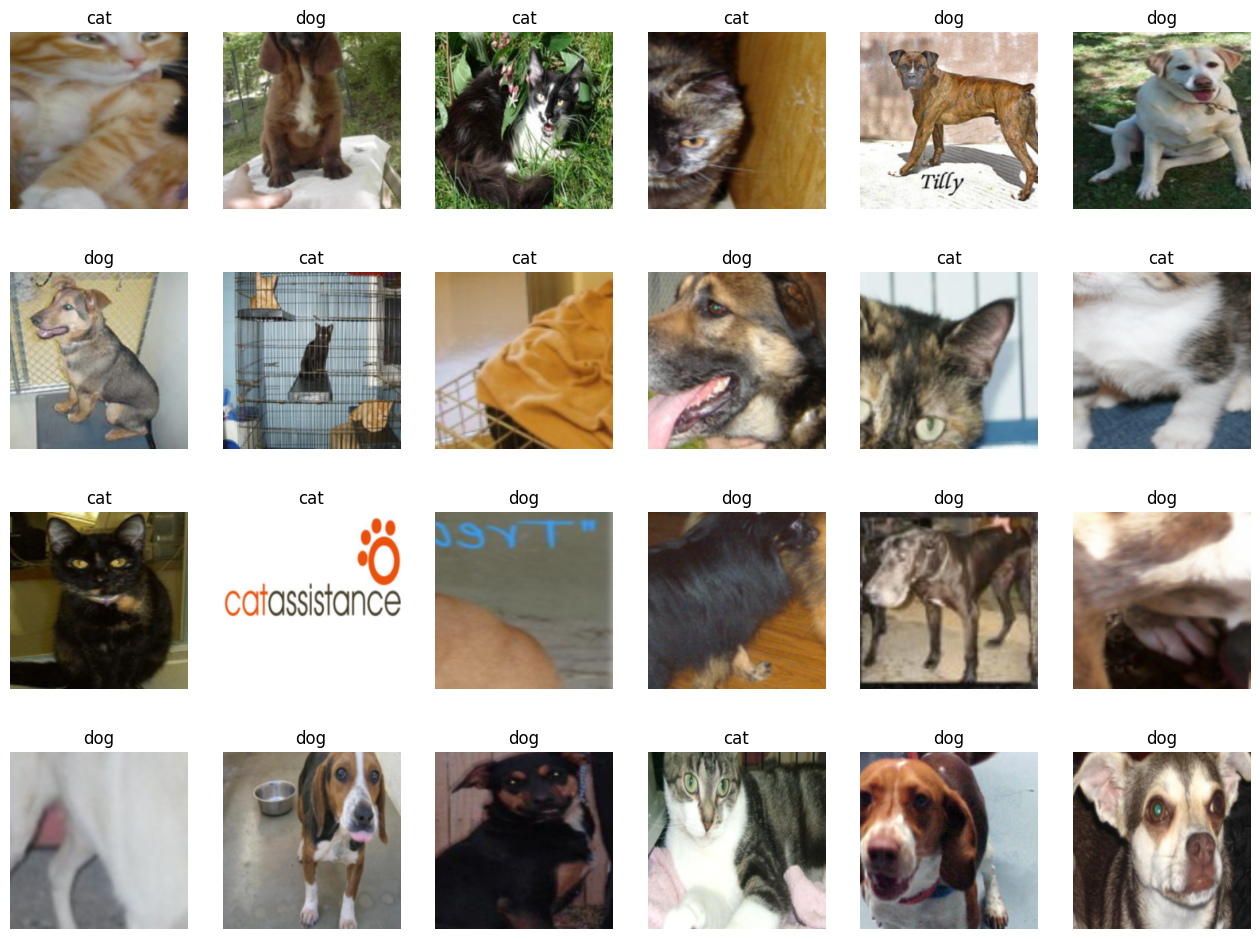

In [3]:
samples, labels = iter(train_loader).next() 
classes = { 0:'cat' , 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy() , (1,2,0)))
plt.subplots_adjust(bottom=0.2 , top=0.6 , hspace=0)

In [4]:
resnet18 = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\kwons/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [5]:
def set_parameter_requires_grad(model , feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False 


set_parameter_requires_grad(resnet18)


In [6]:
resnet18.fc = nn.Linear(512,2)

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name,param.data)

fc.weight tensor([[-0.0062, -0.0130,  0.0039,  ...,  0.0402,  0.0277, -0.0248],
        [-0.0154,  0.0105,  0.0323,  ...,  0.0213, -0.0192,  0.0267]])
fc.bias tensor([-0.0111,  0.0220])


In [7]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512,2)
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
def train_model(model,dataloaders ,criterion, optimizer ,device, num_epochs=13 , is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_corrects = 0

        for inputs , labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs ,1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss/ len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)

        print('Loss: {:.4f} Acc:{:.4f}'.format(epoch_loss , epoch_acc))

        if epoch_acc > best_acc :
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)

        torch.save(model.state_dict() , os.path.join('../pytorch/pytorch_data/chap05/data/catanddog/' , '{0:0=2d}.pth'.format(epoch)))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //60 , time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))
    return acc_history , loss_history

In [9]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print('\t' , name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist , train_loss_hist = train_model(resnet18 , train_loader , criterion , optimizer , device)

Epoch 0/12
----------


c:\Users\kwons\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loss: 0.6195 Acc:0.6623

Epoch 1/12
----------
Loss: 0.3970 Acc:0.8468

Epoch 2/12
----------
Loss: 0.3577 Acc:0.8494

Epoch 3/12
----------
Loss: 0.3286 Acc:0.8545

Epoch 4/12
----------
Loss: 0.2298 Acc:0.9169

Epoch 5/12
----------
Loss: 0.3192 Acc:0.8494

Epoch 6/12
----------
Loss: 0.3103 Acc:0.8416

Epoch 7/12
----------
Loss: 0.2568 Acc:0.8883

Epoch 8/12
----------
Loss: 0.2764 Acc:0.8753

Epoch 9/12
----------
Loss: 0.2487 Acc:0.8909

Epoch 10/12
----------
Loss: 0.2194 Acc:0.8987

Epoch 11/12
----------
Loss: 0.1836 Acc:0.9299

Epoch 12/12
----------
Loss: 0.2045 Acc:0.9247

Training complete in 5m 5s
Best Acc: 0.929870


In [11]:
from random import shuffle


test_path = '../pytorch/pytorch_data/chap05/data/catanddog/test'
transform  = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle = True
)

print(len(test_dataset))

98


In [16]:
def eval_model(model , dataloaders , device):
    since = time.time()
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('../pytorch/pytorch_data/chap05/data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model' , saved_models)

    for model_path in saved_models:
        print('Loading model' , model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0 

        for inputs ,labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)

            _, preds = torch.max(outputs.data ,1)
            preds[preds >= 0.5] =1 
            preds[preds <0.5] = 0
            running_corrects += preds.eq(labels.cpu()).int().sum()

        
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc
        acc_history.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f} m {:.0f}s'.format(time_elapsed//60 , time_elapsed%60))
    print('Best Acc: {:4f}'.format(best_acc))

    return acc_history




In [17]:
val_acc_hist = eval_model(resnet18 , test_loader , device)

saved_model ['../pytorch/pytorch_data/chap05/data/catanddog\\00.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\01.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\02.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\03.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\04.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\05.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\06.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\07.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\08.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\09.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\10.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\11.pth', '../pytorch/pytorch_data/chap05/data/catanddog\\12.pth']
Loading model ../pytorch/pytorch_data/chap05/data/catanddog\00.pth
Acc: 0.8061

Loading model ../pytorch/pytorch_data/chap05/data/catanddog\01.pth
Acc: 0.9388

Loading model ../pytorch/pytorch_data/chap05/data/catanddog\02.pth
Acc: 0.9286

Loadin

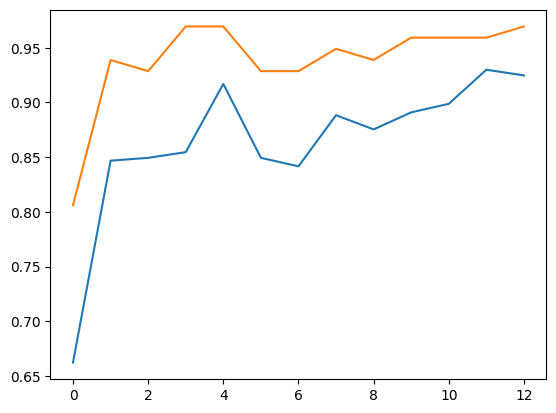

In [19]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

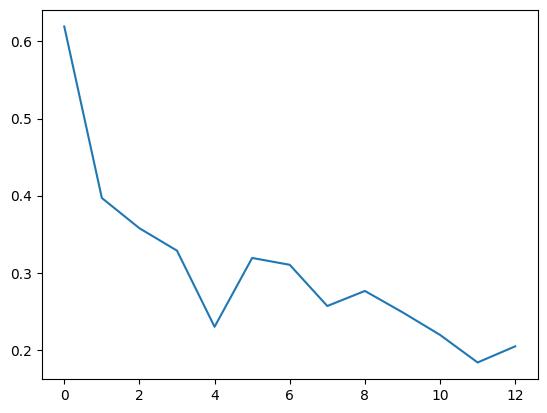

In [20]:
plt.plot(train_loss_hist)
plt.show()


In [21]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1,2,0)
    image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
    image = image.clip(0,1)
    return image

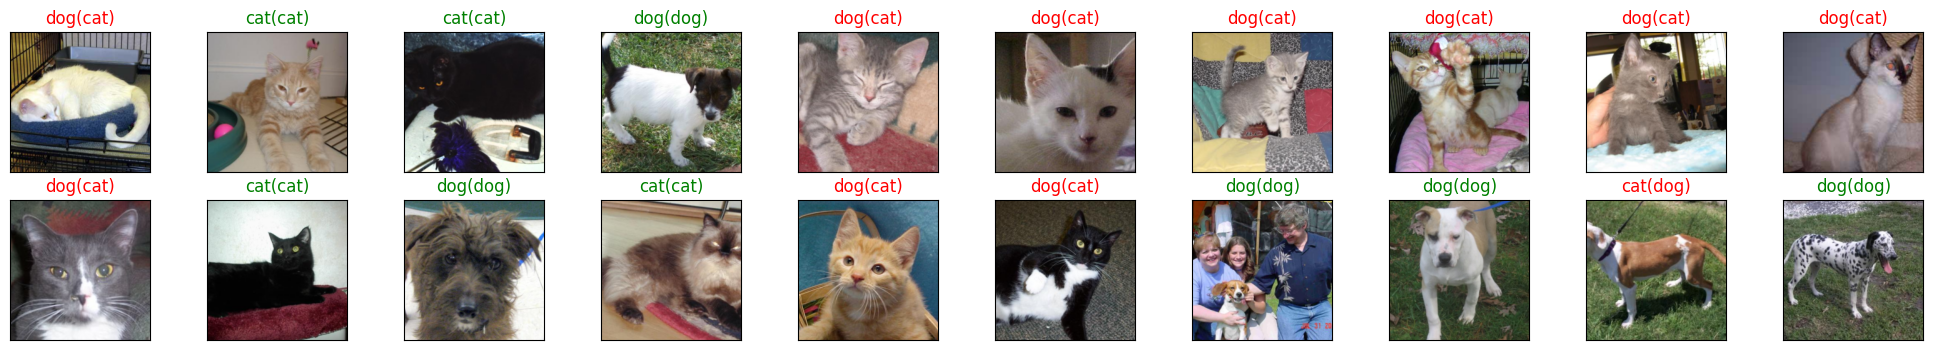

<Figure size 640x480 with 0 Axes>

In [25]:
classes = { 0:'cat' , 1:'dog'}

dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output,1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2,10, idx+1 , xticks=[] , yticks=[])
    plt.imshow(im_convert(images[idx]))
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom=0.2 , top=0.6 , hspace=0)

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision

import torchvision.transforms as transforms
import torchvision.models as models
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [5]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3 , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64,64 ,kernel_size=3 ,padding=1 , bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            nn.Conv2d(64,128 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128,128 , kernel_size=3 ,padding=1 , bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            nn.Conv2d(128,256 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256,256 , kernel_size=3 ,padding=1 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Conv2d(256,256 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2 , stride=2),

             nn.Conv2d(256,512 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512 , kernel_size=3 ,padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Conv2d(512,512 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2 , stride=2),

            nn.Conv2d(512,512 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512,512 , kernel_size=3 ,padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            
            nn.Conv2d(512,512 , kernel_size=3, padding=1 , bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2 , stride=2),


        )
        self.classifier = nn.Sequential(
            nn.Linear(512,512,bias=False) ,
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1,512)
        x = self.classifier(x)
        return F.log_softmax(x)


In [6]:
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [7]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    def hook_fn(self , module ,input ,output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()
        

torch.Size([1, 3, 100, 100])


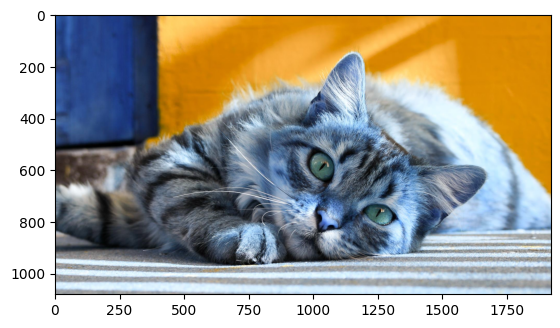

In [8]:
img = cv2.imread('../pytorch/pytorch_data/chap05/data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100,100) , interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

In [9]:
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

c:\Users\kwons\anaconda3\envs\torch_book\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\Users\kwons\AppData\Local\Temp\ipykernel_1316\1100291948.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


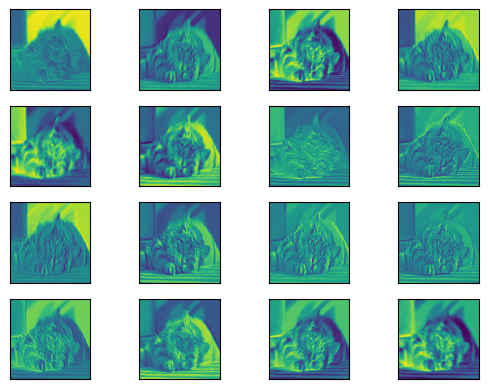

<Figure size 1200x800 with 0 Axes>

In [11]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0 , right=1 , bottom=0 , top=1 , hspace=0.05 , wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])

plt.show()

In [12]:
result = LayerActivations(model.features,20)

model(img)
activations = result.features

C:\Users\kwons\AppData\Local\Temp\ipykernel_1316\1100291948.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


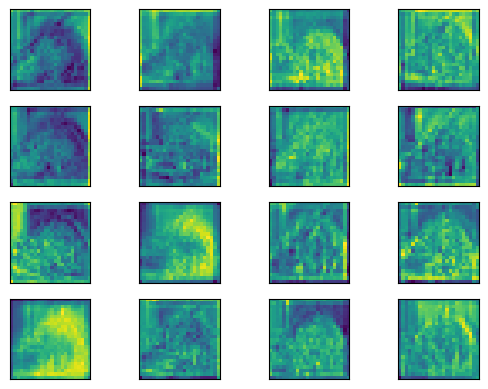

<Figure size 1200x800 with 0 Axes>

In [13]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0 , right=1 , bottom=0 , top=1 , hspace=0.05 , wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])

plt.show()

In [14]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

C:\Users\kwons\AppData\Local\Temp\ipykernel_1316\1100291948.py:80: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


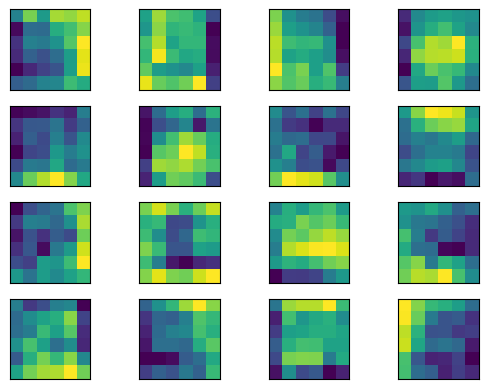

<Figure size 1200x800 with 0 Axes>

In [15]:
fig, axes = plt.subplots(4,4)
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(left=0 , right=1 , bottom=0 , top=1 , hspace=0.05 , wspace=0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + column])

plt.show()